# Introducción
El contexto del trabajo es la generacion de energıa electrica a traves de paneles fotovoltaicos que transforman la radiacion lumınica solar en energıa electrica. El objetivo del trabajo es responder las siguiente pregunta: ¿cual es la mejor forma de cambiar la direccion de un panel solar para maximizar la ganancia obtenida en energıa con respecto al costo del movimiento?¿Es esto siempre igual sin importar el clima y la temporada?.

Dado que contamos con sets de datos con respecto al sol (que serán descritos posteriormente), nos interesa responder estas preguntas para este set de datos en particular.

# Modelo Conceptual
Para modelar la actividad de un panel fotovoltaico, vamos a, en primer lugar, identificar los actores que tendrán lugar en nuestro modelo y sus comportamientos. Comenzamos con el sol, que emite todo tipo de radiación con una cierta intensidad y en todas las direcciones, nosotros solo tomaremos en cuenta la dirección de la radiación lumínica que va hacia nuestro panel y el ángulo relativo que tiene la cara con celdas fotovoltaicas del panel respecto a nuestro sol (y por ende a la direccion de la luz). Basado en estos parámetros, el panel fotovoltaico podrá captar una determinada cantidad de luz que transformará en energía eléctrica mediante algún proceso interno el cual ignoramos. Además, con objetivo de maximizar la radiación captada (y así, la energía eléctrica generada), el panel solar cuenta con un motor que permite, con cierto costo, mover el panel cierto ángulo con respecto a un único eje. La siguiente figura ilustra nuestro modelo simplificado. 

<img src='img/PanelSolar-Conceptual.png' width="400" height="100" />

Modelaremos entonces a los diferentes actores de la siguiente manera:
1. *Sol*: como modelo atómico que actúa como generador de radiación, en base a una dirección relativa al panel dada y cierta distribución de magnitud.
3. *Motor*: como modelo atómico responsable de simular el movimiento del panel solar. En base a un ángulo a moverse obtenidos por puertos de entrada, y en base a un cierto costo de movimiento, escribe por los puertos de salida el costo del movimiento.
4. *Controlador*: como modelo atómico responsable de determinar cuando se activara el motor y qué movimiento hará, basado en una tolerancia de ángulo de radiación y a la cantidad de energía que se esta generando en ese instante. Además contiene una batería como variable de estado.
5. *Panel Solar*: como modelo acoplado que contiene un controlador, un motor y una batería. Además, recibe por puertos de entrada la magnitud y ángulo de la radiación, una tolerancia al ángulo para efectuar un movimiento, y un costo por movimiento.

Con este modelo intentaremos responder a las preguntas planteadas basados en sets de datos reales de radiación solar según las estaciones y distintos climas, rendimiento de paneles fotovoltaicos a diversos ángulos y consumos de motores eléctricos.

# Modelos Acoplados
Se tiene el siguiente modelo acoplado `top.ma`:
```
[top]
components : sun@sun solar_panel
out : sun_degree sun_radiation obtained_energy consumed_energy battery
link : radiation@sun radiation@solar_panel
link : degree@sun degree@solar_panel
link : radiation@sun sun_radiation
link : degree@sun sun_degree
link : obtained_energy@solar_panel obtained_energy
link : consumed_energy@solar_panel consumed_energy
link : battery@solar_panel battery

[solar_panel]
components : controller@controller solar_cell@solarcell engine@engine
in : radiation degree
out : obtained_energy consumed_energy battery

link : radiation radiation@controller
link : degree degree@controller

link : rotation@controller rotation@engine
link : received_energy@controller received_energy@solar_cell
link : battery@controller battery

link : obtained_energy@solar_cell obtained_energy
link : obtained_energy@solar_cell obtained_energy@controller
link : consumed_energy@engine consumed_energy
link : consumed_energy@engine consumed_energy@controller

[solar_cell]
conversion_factor : 0.4

[engine]
consumption_factor : 5

[controller]
tolerance : 5
min_energy_to_rotate: 10
```

Tenemos, en primer lugar, el modelo acoplado *top*, que es el que utilizamos para la simulación. Por otro lado, el único y más relevante modelo acoplado del problema es *panel_solar*. El siguiente diagrama modela las conexiones entre los puertos de los modelos:

<img src='img/Diagrama-Conexiones.png' width="800" height="400" />

Si miramos el proceso como una secuencia de mensajes, lo que entendemos es que primero el sol emite una cierta radiación con cierto ángulo que impacta sobre el panel solar, y éste analiza estos valores desde su controlador desde donde se calcula, en primer lugar, la energía obtenida por la celda solar y, en segundo lugar, una rotación mediante el motor en caso de ser necesario, en donde en particular vamos a considerar que será necesario realizar el movimiento si y solo si la diferencia entre el ángulo del sol y el del panel supera un umbral de tolerancia, especificado como parámetro del controlador (esto será detallado posteriormente). 

El flujo de mensajes entre los modelos pueden entenderse con el siguiente diagrama de secuencias

<img src='img/PanelSolar-DiagramaSeq.png' width="800" height="400" />


# Modelos Atómicos

## Sol

Es un modelo atómico que actúa como generador. No tiene ningún puerto de entrada y tiene 2 puertos de salida:
1. **radiation**: por donde se emite un valor correspondiente a la radiación solar (medida en kW-hr/m^2) para un instante de tiempo.


2. **degree**: por donde se emite un valor correspondiente al ángulo solar con respecto al piso en el que se encuentra el panel (medida en grados) para un instante de tiempo.

Los datos emitidos por estos puertos se corresponden a datos reales obtenidos de https://power.larc.nasa.gov/data-access-viewer/ para los datos de las radiaciones solares y de https://www.esrl.noaa.gov/gmd/grad/solcalc/calcdetails.html para el calculo de todos los angulos. En particular, alojamos ambos valores en distintos archivos: *datos_radiaciones* y *datos_angulos*. Para el primer archivo, tenemos que cada entrada (medidos en *kW-hr/m^2) se corresponde al promedio de radiación por día con los datos de todo un año. Mientras que el segundo, tenemos que cada entrada describe el ángulo del sol por cada 6 minutos, a lo largo de un día. 

El único estado posible de este modelo es *EMITIENDO_RADIACION*.
```
init():
    datos_radiaciones <- abrir_archivo_radiaciones()
    datos_angulos <- abrir_archivo_angulos()
    radiacion <- leer_prox_entrada(datos_radiaciones)
    angulo <- leer_prox_entrada(datos_angulos)
    hold_in(6m)
```
Empezamos leyendo los primeros valores de cada archivo, manteniéndonos durante 6 minutos en el mismo estado. Luego, dado que el modelo actúa como generador y, en particular, no tiene puertos de entradas, su `deltaExterna` no hace nada. Por otro lado, al finalizar el estado (`sigma=ta`), lo que hacemos es primero emitir por los puertos de salida los valores de radiación y ángulo con la siguiente función:
```
output()
	send_output(radiation, radiacion);
	send_output(degree, angulo);
```
Luego, en la `deltaInterna`  lo que haremos será mantenernos en el mismo estado actualizando los valores de radiación y ángulo según corresponda, obtenidos de los datos utilizados.
```
deltaInterna(mensajeInterno):
    if (fin_archivo(datos_angulos)):
        resetear(datos_angulos)
        if (fin_archivo(datos_radiaciones)):    
            resetear(datos_radiaciones)
        radiacion <- leer_prox_entrada(datos_radiaciones)
    angulo <- leer_prox_entrada(datos_angulos)
 
    hold_in(6min)
``` 
Esta lógica proviene de la forma en la que tenemos los datos de las radiaciónes y ángulos: para `datos_radiaciones`, tenemos que cada entrada se corresponde con el promedio de radiación en un día, mientras que cada entrada de `datos_angulos` describe el ángulo del sol en 6 minutos. Luego, la idea es mantener fija la radiación e ir recorriendo todos los ángulos hasta terminar de leer el último ángulo --que se corresponde con la finalización del día--, para luego leer el próximo valor de radiación y resetear `datos_angulos` --que se corresponde con el comienzo de un nuevo día. Al finalizar con el último valor de radiación, reseteamos `datos_radiaciones` para seguir indefinidamente con la simulación. Notar que de esta forma la radiación emitida resulta constante y el ángulo varía a lo largo del día. 

En consecuencia resulta que, cada 6 minutos, el sol emite una cierta radiación con cierto ángulo por sus puertos de salida.

## Celda solar

Es un modelo atómico que representa al conjunto de celdas del panel solar. Cuenta con un único puerto de entrada, **received_energy**, por donde recibe una cierta cantidad de energía. De ésta, sólo absorberá una parte, que dependerá de su único parámetro **conversion_factor** y, luego de cierto cálculo, comunicará la energía obtenida por su único puerto de salida, **obtained_energy**.

El modelo cuenta con un único estado posible, *ABSORBING_ENERGY*. 
```
init():
	conversion_factor <- cargar_param('conversion_factor')
	passivate()
```
Dado que el modelo es reactivo, empieza pasivado hasta que reciba energía por su puerto de entrada.
```
deltaExterna(mensajeExterno):
	if mensajeExterno.port() = 'received_energy':
		received_energy <- mensajeExterno.value()
		obtained_energy <- conversion_factor * received_energy;
		hold_in(0)
```
Al recibir energía por su puerto de entrada `received_energy`, se calcula la energía obtenida y forzamos un cambio de estado. Luego, lo primero que sucede es el llamado a la función `output`:
```
output():
	send_output('obtained_energy', obtained_energy)
```
Cuyo resultado será que se emita por su puerto de salida la energía obtenida. Luego, realizamos el cambio de estado: 
```
deltaInterna(mensajeInterno):
	passivate()
```
Pasivando el modelo en espera de nueva energía recibida.


## Motor

Es un modelo atómico que representa el motor del Panel Solar, que lo rota con respecto a un único eje. Cuenta con un único puerto de entrada, **rotation**, por donde recibe un ángulo de rotación que debe efectuar. Luego, al realizar la rotación pedida, emitirá por su único puerto de salida **consumed_energy** la energía consumida al realizar el movimiento pedido, cuyo valor dependerá de su único parámetro **consumption_factor**.
  
El modelo cuenta con un único estado posible, *ROTATING_PANEL*.
```
init():
    consumption_factor <- cargar_param('consumption_factor')
    passivate()
```

Dado que el modelo es reactivo, empieza pasivado hasta que reciba un valor a rotar por su puerto de entrada.
```
deltaExterna(mensajeExterno):
    if mensajeExterno.port() = 'rotation':
        rotation <- mensajeExterno.value()
        consumed_energy <- consumption_factor * rotation;
        hold_in(0)
```
Al recibir un valor a rotar por su puerto de entrada `rotation`, se calcula el costo consumido por la rotación pedida y forzamos un cambio de estado. Luego, lo primero que sucede es el llamado a la función `output`:
```
output():
    send_output('consumed_energy', consumed_energy)
```
Cuyo resultado será que se emita por su puerto de salida el costo de haber efectuado la rotación pedida. Luego, realizamos el cambio de estado:
```
deltaInterna(mensajeInterno):
    passivate()
```
Pasivando el modelo en espera de un nuevo valor de rotación.


## Controlador

Es un modelo atómico que representa el controlador del Panel Solar.  Cuenta con las siguientes variables de estado internas:
1. **current_degree**: ángulo actual del panel solar.
2. **battery**: energía neta almacenada.

Además, el modelo cuenta con los siguientes parámetros: 
3. **tolerance**: diferencia máxima (entre el ángulo del sol y el ángulo actual del panel) a tolerar para la realización de la rotación del panel. Cuanto menor sea este valor, más rotaciones son esperadas. 
4. **min_energy_to_rotate**: cantidad de energía mínima para realizar una rotación.

Por otro lado, cuenta con siguientes puertos de entrada:
5.	**radiation**:  por donde recibe el valor de radiación recibida por el panel.
6.	**degree**: por donde recibe el ángulo de la radiación recibida por el panel.
7.	**obtained_energy**:  por donde recibe un valor de energía obtenida.
8.	**consumed_energy**: por donde recibe un valor de energía consumida.

Los puertos de `radiation` y `degree` son utilizados para generar el flujo de absorción de energía y eventuales movimientos del panel -- cuya realización dependen del parámetro `tolerance`--, mientras que los puertos `obtained_energy` y `consumed_energy` son utilizados como medios de notificación para actualizar variables de estado internas. 

Por último, se tiene los siguientes puertos de salida:
1. **received_energy**: energía recibida (en base a la radiación y ángulo recibidos)
2. **rotation**: ángulo a rotar.
3. **battery**: cantidad de energía almacenada hasta el momento.
  
El conjunto de estados posibles son los siguientes: *AWAITING_RADIATION*, *AWAITING_DEGREE*, *PROCESSING_ENERGY*.

Al inicializar el modelo, realizamos lo siguiente:
```
init():
	tolerance <- cargar_param('tolerance')
	min_energy_to_rotate <- cargar_param('min_energy_to_rotate')
	current_degree <- 0
	rotation <- 0
	received_energy <- 0
	received_radiation <- false
	received_degree <- false
	battery_update <- false
	passivate()
```

Como el modelo es reactivo, lo pasivamos a la espera de un nuevo mensaje. 
```
deltaExterna(mensajeExterno):
	value <- mensajeExterno.value()
	if mensajeExterno.port() = 'radiation':
		received_radiation <- true
		radiation <- value;
	else if mensajeExterno.port() = 'degree':
		received_degree <- true
		degree <- value
	else if mensajeExterno.port() = 'obtained_energy':
		battery_update <- true
		battery <- battery + value
	else if mensajeExterno.port() = 'consumed_energy': 
		battery_update <- true
		battery <- battery - value
	hold_in(0)
	if received_radiation && received_degree:
		if 0 <= degree <= 180:
			received_radiation, received_degree <- false;
			received_energy <- calcular_energia_recibida(radiation, degree, current_degree)
			if difference(current_degree, degree) > tolerance && battery > min_battery_to_move:
				current_degree <- degree;
				rotation <- difference(current_degree, degree);
```	
Acá pueden pasar dos cosas en líneas generales. La primera es que el mensaje externo se corresponda con una notificación de `obtained_energy` o `consumed_energy`, que generará una actualización en el estado de la batería. La segunda es que sea un valor de `radiation` o `degree`, en cuyo caso guardaremos los valores y esperaremos a tener ambos, para realizar la lógica de rotación y absorción de energía. 

En primer lugar,  si 0 <= degree <= 180, consideramos que es de día y entonces se recibe una cantidad no nula de energía; caso contrario no tiene sentido realizar ninguna rotación (`rotation <- 0`) y la energía recibida será nula (`received_energy <- 0`). Suponiendo entonces que es de día, lo que hacemos entonces es calcular la energía recibida y el ángulo a rotar.

Con respecto a la energía recibida, la calculamos con la siguiente ecuación:
E = A * r * H * PR

Donde:
E = Energy(kWh), es la energía en forma de radiación que nos da el sol
A = área total del panel solar (m²)
r = rendimiento del panel solar (%)
H = promedio anual de radiación solar p en paneles inclinados (sin sombras)
PR = razón de performance, coeficiente por pérdidas (rango entre 0.5 y 0.9, valor promedio 0.75)

Sabemos que r es el rendimiento del panel solar dado por la razón de poder eléctrico de un panel dividido por su área, en general depende del diseño y de la calidad de los materiales del panel, en general se encuentra entre el 40% y el 70% en casos muy especiales de diseños ultra eficientes (y caros).

Eliminamos PR del cálculo porque es un factor de la red que de momento no nos interesa analizar, esta en la ecuación para el cálculo de instalaciones grandes de granjas solares que se escapa al alcance de este trabajo práctico.

Tomamos r = 0.5 como valor inicial, eventualmente podría ser un parámetro a modificar para probar más configuraciones posibles.

No obtuvimos el dato H pero igualmente planeabamos calcular el área del panel incidida por la radiación según los ángulos relativos que tengan, lo que entendemos reemplaza correctamente a H en el cálculo. 
El lado que se modifica del área irradiada del panel va a ser el coseno del valor absoluto del ángulo relativo entre el ángulo de elevación del sol y el ángulo de inclinación del panel, todo esto multiplicado por el lado real del panel. finalmente, con este lado, multiplicado por el otro lado del panel, nos da exactamente el área incidida por la radiación solar, esta es A para nosotros.


In [19]:
# %load_ext autoreload
# %autoreload 2

import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from util_analysis import *

Primero parseamos los datos que obtenemos del output para que sea más cómodo

In [65]:
df = fetch_sim_data('vtol-')

Processing file vtol-tol-5
Processing file vtol-tol-3
Processing file vtol-tol-15
Processing file vtol-tol-0.5
Processing file vtol-tol-25
Processing file vtol-tol-1
Processing file vtol-tol-20
Processing file vtol-tol-10


Primero analizamos el comportamiento del sol

In [66]:
df['sun_degree'] = df['sun_degree'].apply(lambda x: float(x))
df['sun_radiation'] = df['sun_radiation'].apply(lambda x: float(x))

Radiación: 6.17


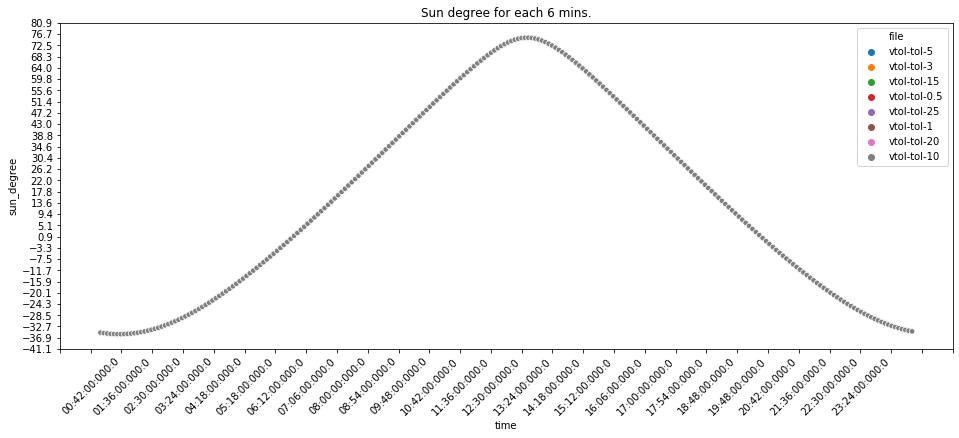

In [67]:
# plt.figure(figsize=(16, 6))
# ax1 = sns.scatterplot(x='time', y='sun_radiation',data=df, hue='file', s=30)
# ax1.xaxis.set_major_locator(ticker.LinearLocator(30))
# plt.xticks(rotation=45, ha='right')
# plt.title("Sun radiation for each 6 mins.")
# plt.show()

print('Radiación: ' + str(df['sun_radiation'].iloc[-1]))

plt.figure(figsize=(16, 6))
ax2 = sns.scatterplot(x='time', y='sun_degree',data=df, hue='file', s=30)
ax2.xaxis.set_major_locator(ticker.LinearLocator(30))
ax2.yaxis.set_major_locator(ticker.LinearLocator(30))
plt.xticks(rotation=45, ha='right')
plt.title("Sun degree for each 6 mins.")
plt.show()

Ahora analizamos la energía neta obtenida. Para ello, agregamos una columna con las energía neta obtenida en cada instante

In [68]:
obtained_energies =df['obtained_energy'].apply(lambda x: float(x))
consumed_energies = df['consumed_energy'].apply(lambda x: float(x))
df['net_obtained_energy'] = obtained_energies - consumed_energies

In [69]:
def valor_de_param(y):
    return float(y.split('-')[-1])


files_ordenados = sorted(df['file'].unique(), key=valor_de_param)

Seleccionamos distintas tolerancias con el resto de los parámetros fijos y miramos en cada instante la energía neta obtenida en cada instante durante 1 día.

Los valores previos a las 6hs y posteriores a las 20hs fueron omitidos dado que son nulos.

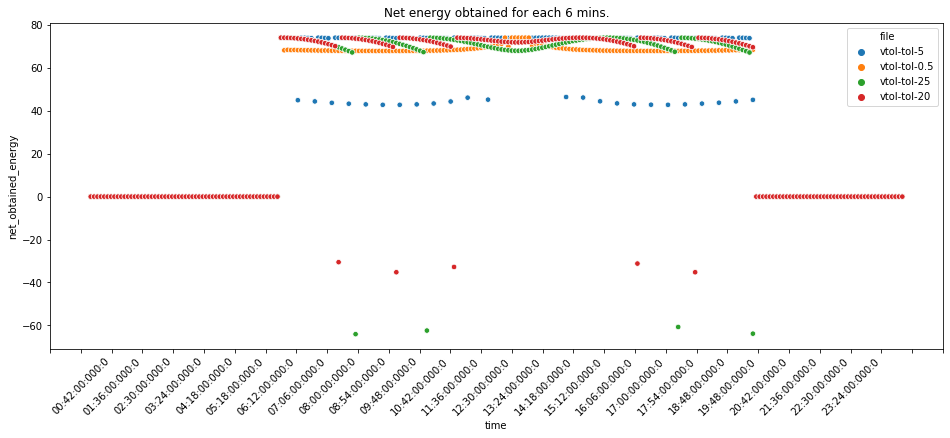

In [73]:
plt.figure(figsize=(16, 6))

selected_files = ['vtol-tol-0.5', 'vtol-tol-5', 'vtol-tol-20', 'vtol-tol-25']
df2 = df[df['file'].isin(selected_files)]
ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df2, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
#plt.ylim(bottom=50)
plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

Lo que puede verse  es que partiendo con una tolerancia baja, la ganancia en cada instante es menor pero se mantiene en el tiempo. Por el contrario, con las otras tolerancias se ve como empieza con una ganancia alta y va decreciendo (cuando el sol empieza a alejarse con respecto al ángulo del panel) hasta que eventualmente se supera el umbral de tolerancia efectuando el movimiento y así volviendo a obtener mucha energía. 

Nos interesa saber el rendimiento al finalizar el día, por lo cual en el próximo experimento vamos a analizar las energías capturadas por las baterías correspondientes a cada simulación, pero ahora considerando más tolerancias posibles para ver cuál conviene tomar para éste día y parámetros fijados en particular.

Tomamos entonces el último valor de la batería en cada simulación, que nos dice cuanta energía neta se acumuló en total.

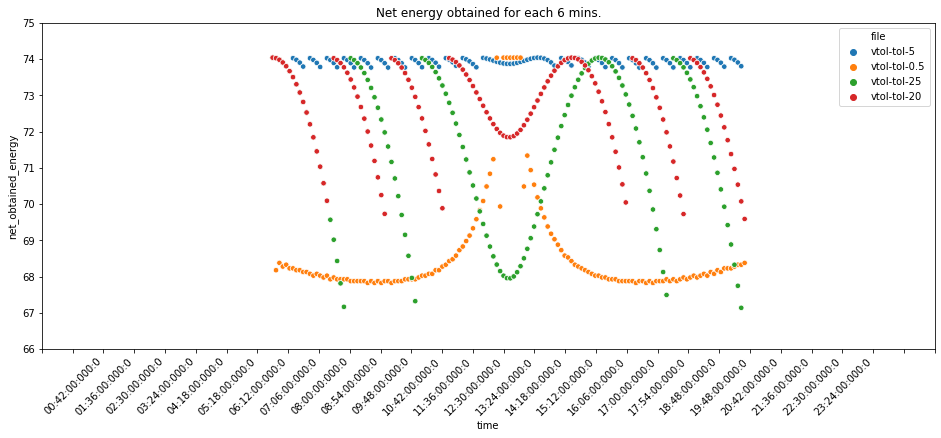

In [94]:
plt.figure(figsize=(16, 6))

selected_files = ['vtol-tol-0.5', 'vtol-tol-5', 'vtol-tol-20', 'vtol-tol-25']
df2 = df[df['file'].isin(selected_files)]
ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df2, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
plt.ylim(bottom=66, top=75)
plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

In [82]:
batteries = df.groupby('file')['battery'].last().reset_index()
batteries['battery'] = batteries['battery'].apply(lambda x: float(x))
batteries

,file,battery
0,vtol-tol-0.5,9616.04682
1,vtol-tol-1,9613.32435
2,vtol-tol-10,9551.24120
3,vtol-tol-15,9605.49376
4,vtol-tol-20,9642.02795
5,vtol-tol-25,9469.69169
6,vtol-tol-3,9623.34624
7,vtol-tol-5,9630.43818


Text(0.5, 1.0, 'Total net energy obtained by the end of the day')

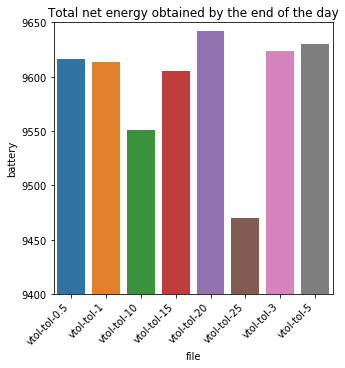

In [91]:
plt.figure(figsize=(5, 5))

ax4 = sns.barplot(x=batteries['file'], y='battery', data=batteries)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=9400, top=9650)
plt.title("Total net energy obtained by the end of the day")

Lo que parece indicar hasta ahora es que conviene tocar tolerancias bajas. Veamos que pasa cuando variamos distintos factores de consumo en el motor.

In [95]:
df_vtol = df
df = fetch_sim_data('vtolcons')

Processing file vtolcons-tol-cons-5-1
Processing file vtolcons-tol-cons-20-20
Processing file vtolcons-tol-cons-1-1
Processing file vtolcons-tol-cons-20-1
Processing file vtolcons-tol-cons-5-20
Processing file vtolcons-tol-cons-1-20


In [96]:
print('Radiación: ' + str(df['sun_radiation'].iloc[-1]))

Radiación: 6.17000


In [97]:
obtained_energies =df['obtained_energy'].apply(lambda x: float(x))
consumed_energies = df['consumed_energy'].apply(lambda x: float(x))
df['net_obtained_energy'] = obtained_energies - consumed_energies

In [98]:
def valor_de_param(y):
    return float(y.split('-')[-1])


files_ordenados = sorted(df['file'].unique(), key=valor_de_param)

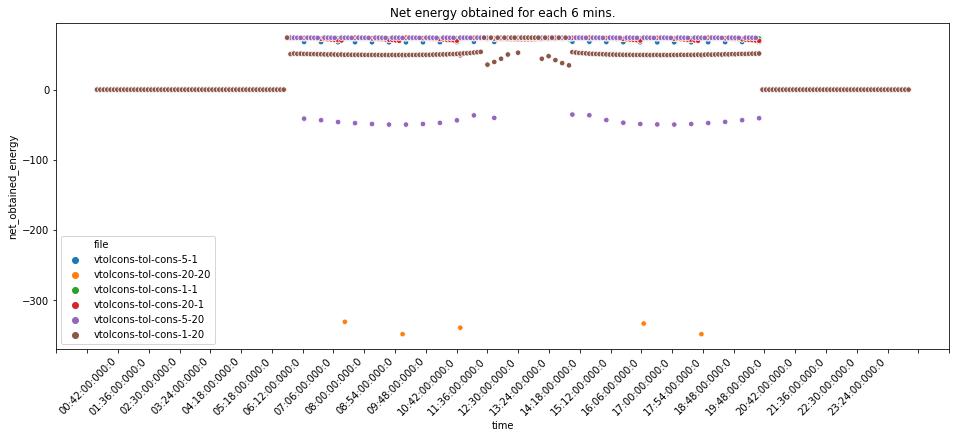

In [106]:
plt.figure(figsize=(16, 6))

selected_files = ['vtolcons-tol-cons-5-1','vtolcons-tol-cons-5-20','vtolcons-tol-cons-1-1', 'vtolcons-tol-cons-20-1', 'vtolcons-tol-cons-1-20', 'vtolcons-tol-cons-20-20'] 
df2 = df[df['file'].isin(selected_files)]
ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df2, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))

plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()



las generaciones netas finales de estos casos son similares, la diferencia es que se puede tener un sistema con alta tolerancia que mas esporadicamente va a mover el panel, pero en este movimiento, dependiendo del consumo del motor, va a generar fluctuaciones muy grandes en la energia neta obtenida en el instante, incluso a veces va a ser negativa al consumir mas de lo que genera, y dependiendo del caso de uso, esto puede ser deseado o problematico.



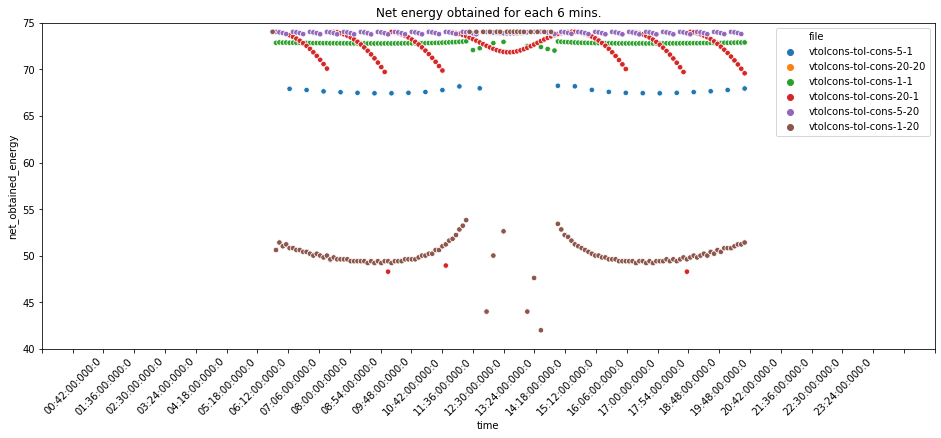

In [111]:
plt.figure(figsize=(16, 6))

selected_files = ['vtolcons-tol-cons-5-1','vtolcons-tol-cons-5-20','vtolcons-tol-cons-1-1', 'vtolcons-tol-cons-20-1', 'vtolcons-tol-cons-1-20', 'vtolcons-tol-cons-20-20'] 
df2 = df[df['file'].isin(selected_files)]
ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df2, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
plt.ylim(bottom= 40,top=75)

plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

In [112]:
batteries = df.groupby('file')['battery'].last().reset_index()
batteries['battery'] = batteries['battery'].apply(lambda x: float(x))
batteries

,file,battery
0,vtolcons-tol-cons-1-1,10213.40439
1,vtolcons-tol-cons-1-20,7363.02420
2,vtolcons-tol-cons-20-1,10051.42793
3,vtolcons-tol-cons-20-20,8106.77796
4,vtolcons-tol-cons-5-1,10200.35822
5,vtolcons-tol-cons-5-20,7493.23801


Text(0.5, 1.0, 'Total net energy obtained by the end of the day')

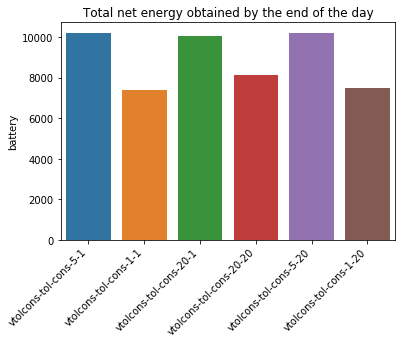

In [113]:
# plt.figure(figsize=(5, 5))

ax4 = sns.barplot(x=files_ordenados, y='battery', data=batteries)
plt.xticks(rotation=45, ha='right')
plt.title("Total net energy obtained by the end of the day")

In [120]:
df_vtolcons = df
df = fetch_sim_data('vexttol')
df

Processing file vexttol-tol-3
Processing file vexttol-tol-6
Processing file vexttol-tol-1
Processing file vexttol-tol-10


,time,file,sun_radiation,sun_degree,obtained_energy,consumed_energy,battery
0,00:06:00:000:0,vexttol-tol-3,9.14000,-35.01000,0.00000,0.00000,0.00000
1,00:12:00:000:0,vexttol-tol-3,9.14000,-35.19000,0.00000,0.00000,0.00000
2,00:18:00:000:0,vexttol-tol-3,9.14000,-35.34000,0.00000,0.00000,0.00000
3,00:24:00:000:0,vexttol-tol-3,9.14000,-35.46000,0.00000,0.00000,0.00000
4,00:30:00:000:0,vexttol-tol-3,9.14000,-35.53000,0.00000,0.00000,0.00000
5,00:36:00:000:0,vexttol-tol-3,9.14000,-35.57000,0.00000,0.00000,0.00000
6,00:42:00:000:0,vexttol-tol-3,9.14000,-35.58000,0.00000,0.00000,0.00000
7,00:48:00:000:0,vexttol-tol-3,9.14000,-35.54000,0.00000,0.00000,0.00000
8,00:54:00:000:0,vexttol-tol-3,9.14000,-35.47000,0.00000,0.00000,0.00000
9,01:00:00:000:0,vexttol-tol-3,9.14000,-35.36000,0.00000,0.00000,0.00000


In [121]:
df['sun_degree'] = df['sun_degree'].apply(lambda x: float(x))
df['sun_radiation'] = df['sun_radiation'].apply(lambda x: float(x))

In [123]:
rad = pd.read_csv("../src/CSV_Seasonal_radiation.csv")
rad

,03,20,6.17
0,3,21,5.55
1,3,22,4.99
2,6,20,3.06
3,6,21,3.09
4,6,22,3.11
5,9,20,3.96
6,9,21,2.18
7,9,22,1.56
8,12,20,8.60
9,12,21,7.11


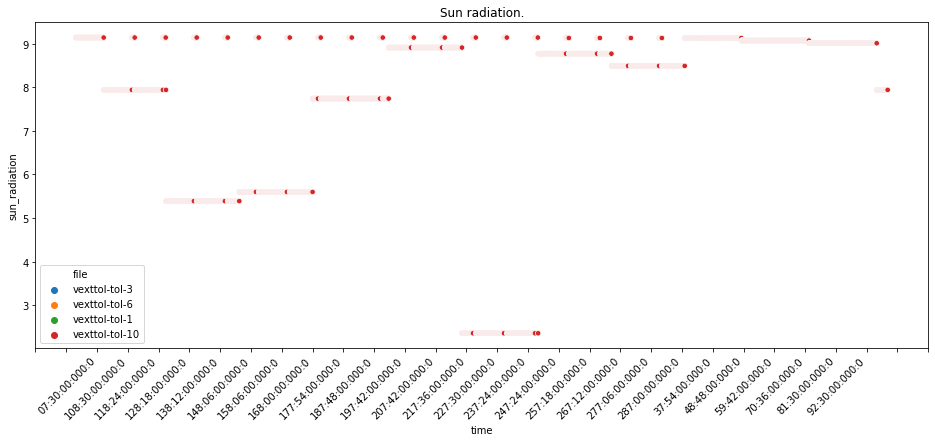

In [122]:
plt.figure(figsize=(16, 6))
ax1 = sns.scatterplot(x='time', y='sun_radiation',data=df, hue='file', s=30)
ax1.xaxis.set_major_locator(ticker.LinearLocator(30))
plt.xticks(rotation=45, ha='right')
plt.title("Sun radiation.")
plt.show()

In [214]:
obtained_energies =df['obtained_energy'].apply(lambda x: float(x))
consumed_energies = df['consumed_energy'].apply(lambda x: float(x))
df['net_obtained_energy'] = obtained_energies - consumed_energies

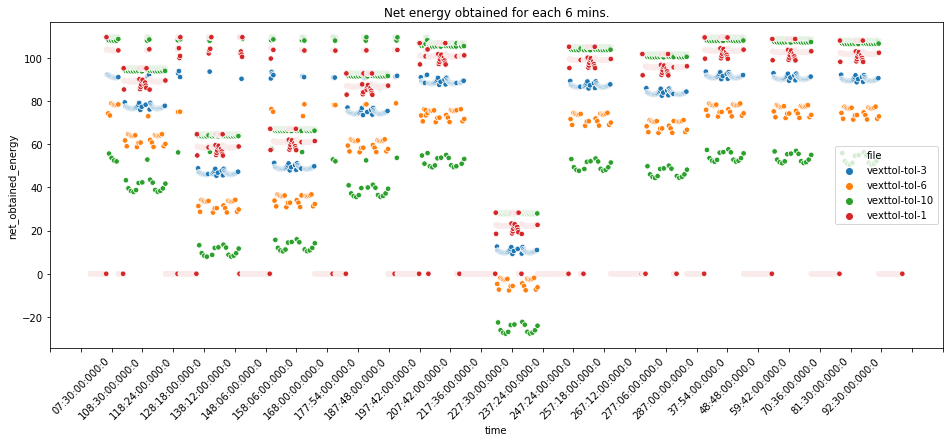

In [215]:
plt.figure(figsize=(16, 6))

ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
# plt.ylim(bottom=50)
plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

In [216]:
batteries = df.groupby('file')['battery'].last().reset_index()
batteries['battery'] = batteries['battery'].apply(lambda x: float(x))
batteries

,file,battery
0,vexttol-tol-1,58059.78260
1,vexttol-tol-10,57691.09100
2,vexttol-tol-3,58134.22395
3,vexttol-tol-6,58067.65111


Text(0.5, 1.0, 'Total net energy obtained by the end of the day')

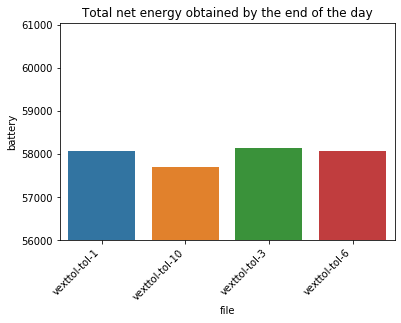

In [217]:
# plt.figure(figsize=(5, 5))

ax4 = sns.barplot(x='file', y='battery', data=batteries)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=56000)
plt.title("Total net energy obtained by the end of the day")

Parece que cuanto mayor es la tolerancia, menor debe ser 